In [1]:
from IPython.display import Image

# DATASET 
- chinook.db

- DB에 대한 설명
- SQL 문들에 대한 설명 부탁드립니다

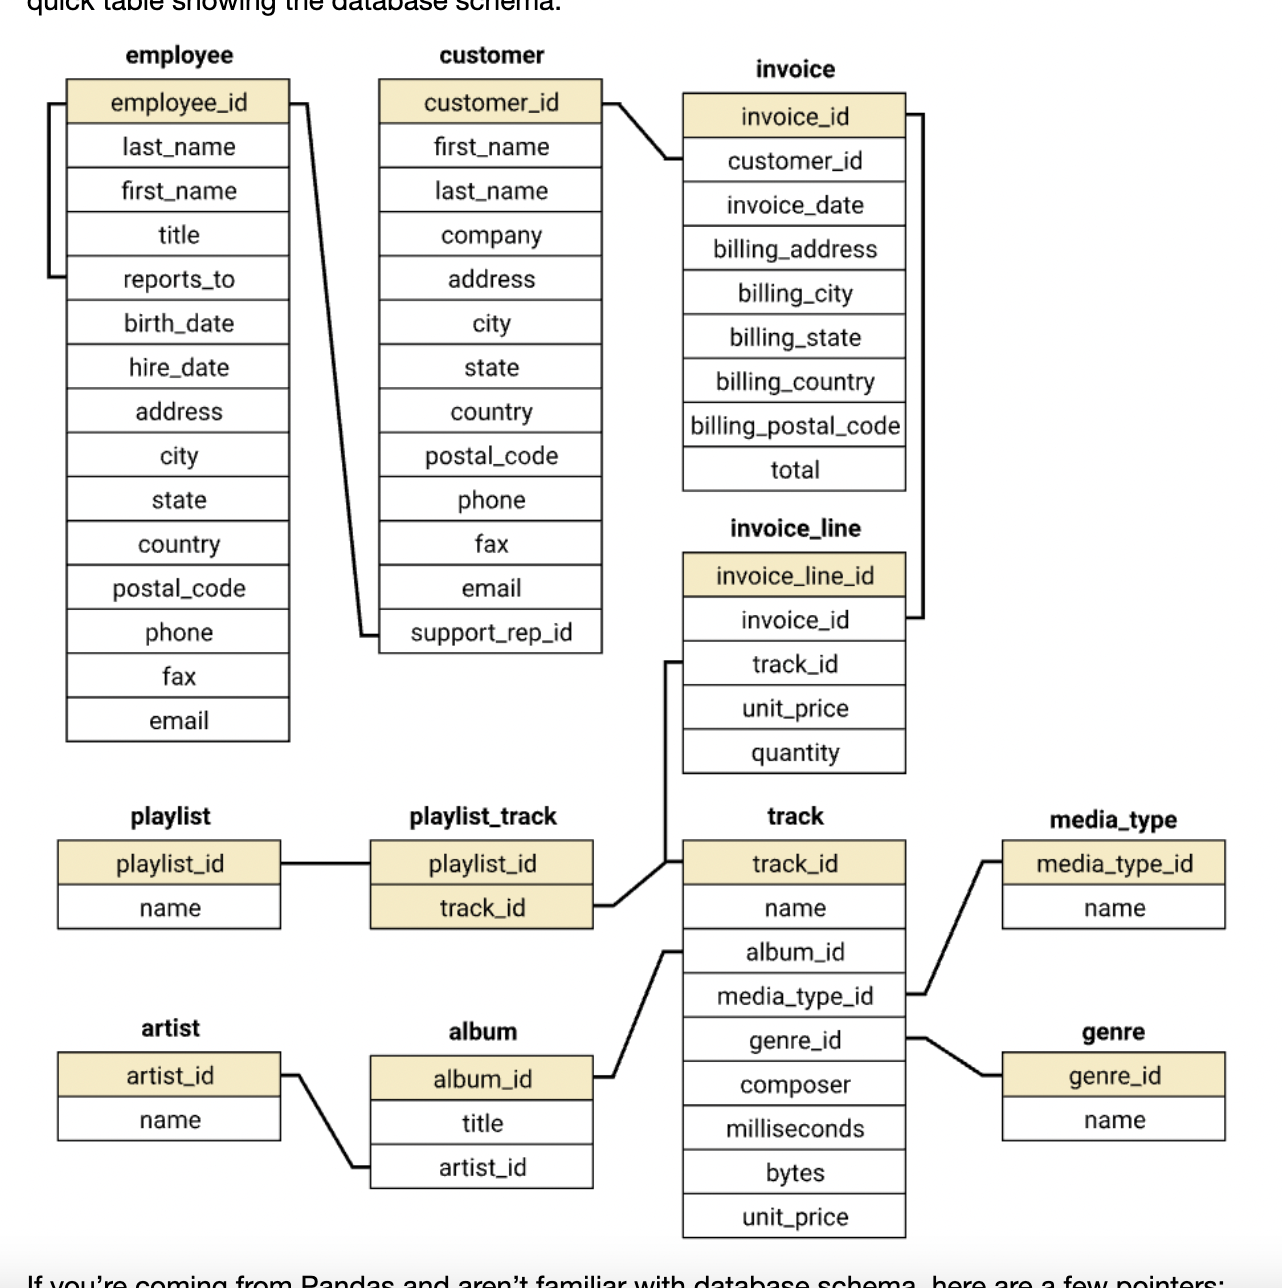

In [2]:
Image('./image/chinook.png')

# connecting database

In [3]:
!pip install plotly

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datapane as dp

In [5]:
import sqlite3
import pandas as pd

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c) 
        
def show_tables():
    q = '''
        SELECT
            name
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

def get_table_row_count(tablename):
    q = '''
        SELECT
            COUNT(1)
        FROM %s;
        ''' % tablename
    return run_query(q)["COUNT(1)"][0]

tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables["name"]]

# Building a dashboard

In [6]:
! pip install datapane
# 초기 셋팅시 datapane 들어가서 인증키 받아와야하는데 이거 셋팅 부분도 한번
# 정리 부탁드려요~

In [7]:
# top10 
import datapane as dp 

top_10_tracks_query = '''
SELECT 
    t.name trackname,
    a.title album_title,
    ar.name artist,
    COUNT(*) as total_purchases,
    SUM(il.unit_price) total_cost
FROM track t 
JOIN album a on a.album_id = t.album_id
JOIN artist ar on ar.artist_id = a.artist_id
JOIN invoice_line il on il.track_id = t.track_id
GROUP BY 1
ORDER BY total_purchases desc
LIMIT 10
'''

top_10_df = run_query(top_10_tracks_query)

dp.Report(
    dp.Table(top_10_df)
).upload(name="Music Sales")

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? More info <a href='https://docs.datapane.com/reports/blocks/layout-pages-and-selects' target='_blank'>here</a>

Report successfully uploaded. View and share your report <a href='https://datapane.com/reports/n3RKVO7/music-sales/' target='_blank'>here</a>, or edit your report <a href='https://datapane.com/reports/n3RKVO7/music-sales/edit/' target='_blank'>here</a>.

# More complex query

In [8]:
employee_sales_performance = '''
WITH 
    customer_support_rep_sales AS
        (
         SELECT 
             i.customer_id,
             strftime('%Y-%m', i.invoice_date) || "-01" Month,
             c.support_rep_id,
             SUM(i.total) Sales_Total
         FROM invoice i
         INNER JOIN customer c ON c.customer_id = i.customer_id
         GROUP BY 2, 3
        )
SELECT
    e.first_name || " " || e.last_name "Employee Name",
    csrs.Month,
    SUM(csrs.Sales_total) "Amount of Sales (in $)"
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON csrs.support_rep_id = e.employee_id
GROUP BY 1, 2;
'''

run_query(employee_sales_performance)

Employee Name       Month  Amount of Sales (in $)
0     Jane Peacock  2017-01-01                   80.19
1     Jane Peacock  2017-02-01                   82.17
2     Jane Peacock  2017-03-01                   32.67
3     Jane Peacock  2017-04-01                   84.15
4     Jane Peacock  2017-05-01                   22.77
..             ...         ...                     ...
136  Steve Johnson  2020-08-01                   25.74
137  Steve Johnson  2020-09-01                   31.68
138  Steve Johnson  2020-10-01                   35.64
139  Steve Johnson  2020-11-01                   30.69
140  Steve Johnson  2020-12-01                    9.90

[141 rows x 3 columns]

In [9]:
employee_sales = run_query(employee_sales_performance)
employee_sales["Month"] = pd.to_datetime(employee_sales["Month"])

employee_sales_monthly = px.line(employee_sales,
                            x = "Month",
                            y = "Amount of Sales (in $)",
                            color = "Employee Name")

employee_sales_monthly.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

employee_sales_monthly.show()

In [10]:
employee_sales_total = employee_sales.groupby(["Employee Name"]) \
                                        .sum() \
                                        .sort_values(by="Amount of Sales (in $)") \
                                        .reset_index()

employee_sales_bar = px.bar(employee_sales_total, 
                            y = 'Employee Name', 
                            x = "Amount of Sales (in $)",
                            text = "Amount of Sales (in $)",
                            orientation = 'h')

employee_sales_bar.update_traces(texttemplate='%{text:.1f}')
employee_sales_bar.show()


# Selecting Albums to Purchase

In [11]:
albums_to_purchase = '''
WITH 
    usa_tracks_sold AS
        (
         SELECT il.* FROM invoice_line il
         INNER JOIN invoice i ON il.invoice_id = i.invoice_id
         INNER JOIN customer c ON i.customer_id = c.customer_id
        )
SELECT 
    g.name Genre, 
    COUNT(uts.invoice_line_id) "Number of Tracks Sold", 
    CAST(COUNT(uts.invoice_line_id) AS FLOAT)/(SELECT COUNT(*) FROM usa_tracks_sold) "Percentage of Tracks Sold"
FROM usa_tracks_sold uts
INNER JOIN track t ON uts.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10;
'''

genre_sales = run_query(albums_to_purchase)
genre_sales.sort_values('Number of Tracks Sold', inplace=True)

genre_sales_plot = px.bar(
    genre_sales, 
    x="Percentage of Tracks Sold", 
    y="Genre", 
    orientation='h',
    text="Percentage of Tracks Sold",
    title = "Sales by Genre"
)

genre_sales_plot.update_traces(texttemplate='%{text:.1%}', textposition='outside')

genre_sales_plot.show()

# ANALYZING SALES BY COUNTRY

In [12]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )


SELECT
    country,
    count(distinct customer_id) customers,
    SUM(unit_price) total_sales,
    SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
    SUM(unit_price) / count(distinct invoice_id) average_order,
    CASE
        WHEN country = "Other" THEN 1
        ELSE 0
    END AS sort
FROM country_or_other
GROUP BY country
ORDER BY sort ASC, total_sales DESC;
'''

run_query(sales_by_country)

country  customers  total_sales  customer_lifetime_value  \
0             USA         13      1040.49                80.037692   
1          Canada          8       535.59                66.948750   
2          Brazil          5       427.68                85.536000   
3          France          5       389.07                77.814000   
4         Germany          4       334.62                83.655000   
5  Czech Republic          2       273.24               136.620000   
6  United Kingdom          3       245.52                81.840000   
7        Portugal          2       185.13                92.565000   
8           India          2       183.15                91.575000   
9           Other         15      1094.94                72.996000   

   average_order  sort  
0       7.942672     0  
1       7.047237     0  
2       7.011148     0  
3       7.781400     0  
4       8.161463     0  
5       9.108000     0  
6       8.768571     0  
7       6.383793     0  
8       8.721429     0  
9       7.448571     1

# sales by Country 

In [13]:
country_metrics = run_query(sales_by_country)

sales_breakdown = go.Figure(data=[go.Pie(
    labels = country_metrics["country"], 
    values=country_metrics["total_sales"], 
    hole=.3)
                                 ])

sales_breakdown.update_layout(title_text="Sales by country")

sales_breakdown.show()


In [14]:
customer_ratio = country_metrics["customers"] / country_metrics["customers"].sum() * 100.0
sales_ratio = country_metrics["total_sales"] / country_metrics["total_sales"].sum() * 100.0


custs_vs_dollars = go.Figure(data=[
    go.Bar(name='Customers', x=country_metrics["country"], y=customer_ratio),
    go.Bar(name='Total Sales', x=country_metrics["country"], y=sales_ratio),
])

# Change the bar mode
custs_vs_dollars.update_layout(barmode='group', title_text="Pct customers vs sales")
custs_vs_dollars.show()

In [15]:
country_metrics["difference_from_avg"] = (country_metrics["average_order"] - \
                                          country_metrics["average_order"].mean()) * 100.0

avg_order = px.bar(
    country_metrics, 
    x = "country", 
    y = "difference_from_avg", 
    color = "country", 
    title = "Avg order - Pct difference from mean",
    labels={
        "country": "Country",
        "difference_from_avg": "Difference from mean (%)"
    }
)

avg_order.update_layout(showlegend=False)

avg_order.show()

In [16]:
clv = px.bar(
    country_metrics,
    x = 'country',
    y = 'customer_lifetime_value',
    color='country',
    labels={
        "country": "Country",
        "customer_lifetime_value": "Customer Lifetime Value ($)"
    },
    title = "Customer Lifetime Value"
)

clv.update_layout(showlegend=False)


clv.show()

# Putting it into a Datapane report

In [17]:
dp.enable_logging()

Configuring datapane logging in library mode


In [18]:
customers = tables[tables["name"]=="customer"]["row_count"].values[0]
employees = tables[tables["name"]=="employee"]["row_count"].values[0]
tracks_sold = tables[tables["name"]=="invoice_line"]["row_count"].values[0]

# 그냥 버전 
r = dp.Report( 
    dp.Group(
        dp.BigNumber(heading="Total customers", value = customers),
        dp.BigNumber(heading="Total employees", value = employees),
        dp.BigNumber(heading="Total tracks sold", value = tracks_sold),
        columns = 3,
        name="Little_group"
    ),
    dp.Plot(genre_sales_plot, name = "genre_sales"),
    dp.Plot(employee_sales_monthly, name = "employee-sales-1"),
    dp.Plot(employee_sales_bar, name = "employee-sales-2"),
    dp.Group(
        dp.Plot(sales_breakdown),
        dp.Plot(custs_vs_dollars),
        dp.Plot(avg_order),
        dp.Plot(clv),
        columns = 2
    ),
    dp.Table(top_10_df, name = "track-sales"),
).upload(name="Interactive Dashboard using SQL")

# 저장 버전
r = dp.Report( 
    dp.Group(
        dp.BigNumber(heading="Total customers", value = customers),
        dp.BigNumber(heading="Total employees", value = employees),
        dp.BigNumber(heading="Total tracks sold", value = tracks_sold),
        columns = 3,
        name="Little_group"
    ),
    dp.Plot(genre_sales_plot, name = "genre_sales"),
    dp.Plot(employee_sales_monthly, name = "employee-sales-1"),
    dp.Plot(employee_sales_bar, name = "employee-sales-2"),
    dp.Group(
        dp.Plot(sales_breakdown),
        dp.Plot(custs_vs_dollars),
        dp.Plot(avg_order),
        dp.Plot(clv),
        columns = 2
    ),
    dp.Table(top_10_df, name = "track-sales"),
).save(path="hello_world.html")

[22:57:09] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-kuruonkp.pl.json (9175 bytes)
[22:57:09] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-vteoovnu.pl.json (14265 bytes)
[22:57:09] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-lr_fy4r1.pl.json (8728 bytes)
[22:57:09] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-31ixlkwv.pl.json (8353 bytes)
[22:57:09] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-oi30hvez.pl.json (8743 bytes)
[22:57:10] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-45950775.pl.json (12664 bytes)
[22:57:10] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-_etyhaut.pl.json (12678 bytes)
[22:57:10] [DEBUG] Saved object to /va

Uploading report and associated data - *please wait...*

[22:57:10] [DEBUG] Successfully Built Report
[22:57:10] [DEBUG] Report size ~0.0 MB
[22:57:11] [DEBUG] Refreshed https://datapane.com/api/reports/O7vdeQA/
[22:57:11] [DEBUG] Proxying 'web_url' lookup to DTO
[22:57:11] [DEBUG] Proxying 'web_url' lookup to DTO


Report successfully uploaded. View and share your report <a href='https://datapane.com/reports/O7vdeQA/interactive-dashboard-using-sql/' target='_blank'>here</a>, or edit your report <a href='https://datapane.com/reports/O7vdeQA/interactive-dashboard-using-sql/edit/' target='_blank'>here</a>.

[22:57:11] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-u_dhk51m.pl.json (9175 bytes)
[22:57:11] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-ypynsigu.pl.json (14265 bytes)
[22:57:11] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-kdn6px0z.pl.json (8728 bytes)
[22:57:11] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-4bcrarkq.pl.json (8353 bytes)
[22:57:11] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-nbu9u2co.pl.json (8743 bytes)
[22:57:11] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-igrzev7n.pl.json (12664 bytes)
[22:57:11] [DEBUG] Saved object to /var/folders/2r/_fr309ls60x8zpqkcdvzvn940000gn/T/dp-tmp-ixfyxikc/dp-tmp-mcu6iobl.pl.json (12678 bytes)
[22:57:11] [DEBUG] Saved object to /va

Report saved to ./hello_world.html